In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from numpy.linalg import cholesky
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn.neighbors import KDTree
from scipy.linalg import sqrtm

from utils.utils import variable_kernel_density_estimation, EDR, find_k_nearest_neighbors
'''
    These are the codes of EDROD(Entropy Density Ratio Outlier Detection)
    Function:
            (1) EDROD can detect the anomaly in the dataset without pretrain,
                which means that you just only need to input the data files and
                it will output the most suspicious data points in the dataset.
            (2) If you have the label, you can use EDROD to calculate the AUC value.
    How to use:
            Step 1: Change the path in 'path' to the location where the data file is stored,
                    and change the parameter 'usecols' in the function 'np.genfromtxt'
            Step 2: If you have the label file, change the path in 'path_label' to the location where the label file is stored.
            Step 3: If you want to find the most suspicious data points, you can change the
                    parameter 'point_num'
            Step 4: If you want to get the AUC value to test the effect of EDROD,
                    you just need to start the program

            Option step: Because different datasets have different features, so you have to
                        change the band width of kernel in the KDE algorithm. If you don't know
                        the best bandwidth, you can use the Grid Search method. However, this method
                        may take a long time to find, if the scale of the parameter 'band with' is wide.

'''

"\n    These are the codes of EDROD(Entropy Density Ratio Outlier Detection)\n    Function:\n            (1) EDROD can detect the anomaly in the dataset without pretrain,\n                which means that you just only need to input the data files and\n                it will output the most suspicious data points in the dataset.\n            (2) If you have the label, you can use EDROD to calculate the AUC value.\n    How to use:\n            Step 1: Change the path in 'path' to the location where the data file is stored,\n                    and change the parameter 'usecols' in the function 'np.genfromtxt'\n            Step 2: If you have the label file, change the path in 'path_label' to the location where the label file is stored.\n            Step 3: If you want to find the most suspicious data points, you can change the\n                    parameter 'point_num'\n            Step 4: If you want to get the AUC value to test the effect of EDROD,\n                    you just need 

In [2]:

if __name__ == '__main__':

    # Load Dataset
    file='1'
    path = 'dataset/synthetic/synthetic_test_'+f"{file}"+'_process.csv'
    data = np.genfromtxt(path, delimiter=',',
                        skip_header=1,usecols=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9))


    #the scale of k
    k_values = list(range(4, 200, 4))
    auc_scores = []



    density = variable_kernel_density_estimation(data)
    # Calculate the covariance matrix and its inverse square root.
    cov_matrix = np.cov(data, rowvar=False)
    sqrt_inv_cov = np.linalg.inv(sqrtm(cov_matrix))

    # Transform the data using the inverse square root of the covariance matrix.
    transformed_data = (data - np.mean(data, axis=0)).dot(sqrt_inv_cov)

    # Construct KDTree
    tree = KDTree(transformed_data, metric='manhattan')

    for k in k_values:
        EDR_Score = np.array([])

        for point in transformed_data:

            md_indices = find_k_nearest_neighbors(point.reshape(1, -1), k, tree)
            md_indices = md_indices.flatten()
            md_nearst_nb = data[md_indices]
            EDR_Score = np.append(EDR_Score, EDR(density, md_indices))



        #Calculate AUC Value
        # Load Label
        df = pd.read_csv(path)
        data_label = df.iloc[:, 10]
        y_true = data_label
        y_pred = EDR_Score / np.sum(EDR_Score)
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)

        auc_scores.append(roc_auc)
        print(roc_auc)

    print("Method:EDROD")
    for k, auc_score in zip(k_values, auc_scores):
        print(f'K={k}, AUC={auc_score}')
    print("Average:",np.average(auc_scores))


0.9641975308641975
0.9723456790123457
0.9762962962962963
0.9769135802469137
0.972716049382716
0.970246913580247
0.972716049382716
0.9740740740740741
0.9724691358024691
0.9723456790123457
0.9718518518518519
0.9723456790123457
0.9716049382716049
0.9718518518518519
0.9720987654320988
0.971604938271605
0.9723456790123457
0.9720987654320987
0.9725925925925926
0.972962962962963
0.9732098765432099
0.9729629629629629
0.9722222222222223
0.9720987654320988
0.972716049382716
0.9729629629629629
0.9733333333333333
0.9730864197530865
0.9724691358024691
0.9719753086419753
0.971604938271605
0.971111111111111
0.971358024691358
0.9712345679012346
0.9707407407407407
0.9706172839506173
0.9707407407407407
0.9706172839506173
0.9701234567901235
0.97
0.969753086419753
0.9698765432098766
0.9693827160493828
0.9693827160493828
0.9688888888888889
0.9686419753086419
0.9685185185185186
0.9679012345679012
0.9682716049382716
Method:EDROD
K=4, AUC=0.9641975308641975
K=8, AUC=0.9723456790123457
K=12, AUC=0.976296296296

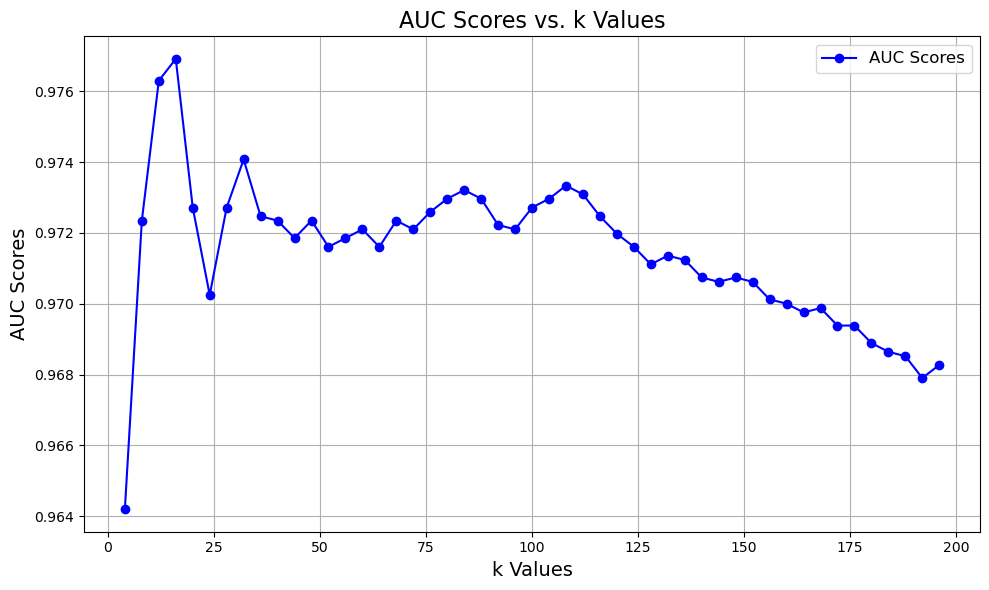

In [3]:
    # Plot a line chart.
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, auc_scores, marker='o', linestyle='-', color='b', label='AUC Scores')
    plt.xlabel('k Values', fontsize=14)
    plt.ylabel('AUC Scores', fontsize=14)
    plt.title('AUC Scores vs. k Values', fontsize=16)
    plt.grid(True)
    plt.legend(loc='best', fontsize=12)
    plt.tight_layout()
    plt.show()